<font size=5>Machine Learning Model Diagnostics and Validation</font>

Updated on July 22, 2022

This demo (based on CalifrniaHousing data, a regression task) covers: 

- Accuracy, WeakSpot and Overfit

- Reliability Testing

- Robustness and Resilience Testing

- Model Comparison and Benchmarking

# Install PiML Toolbox

- Run `!pip install piml` to install the latest version of PiML.
- In Google Colab, we need restart the runtime in order to use newly installed version.

In [ ]:
!pip install PiML

In [15]:
!pip show PiML

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Name: PiML
Version: 0.2.2
Summary: A low-code interpretable machine learning toolbox in Python.
Home-page: https://github.com/SelfExplainML/PiML-Toolbox
Author: Sudjianto, Agus and Zhang, Aijun and Yang, Zebin and Su, Yu and Zeng, Ningzhou and Nair, Vijay
Author-email: None
License: Apache
Location: /usr/local/lib/python3.7/dist-packages
Requires: scikit-learn, xgboost, lightgbm, statsmodels, matplotlib, scipy, pandas, numpy, seaborn, opendatasets, ipywidgets, shap, PyALE, ipython, joblib, xlrd, torch, pygam, lime
Required-by: 


# Load and Prepare Data

- Initilaize a new experiment by `piml.Experiment()`
- Low-code interactive interface, or
- High-code autorun scripts (optional)  


In [1]:
from piml import Experiment
exp = Experiment()

## Low-code Interface

In [ ]:
# Choose CaliforniaHousing_trim2
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [ ]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## High-code Scripts (optional)

In [2]:
exp.data_loader(data='CaliforniaHousing_trim2')

exp.data_summary(feature_exclude=[])

exp.data_prepare(target='MedHouseVal', task_type='Regression', test_ratio=0.2, random_state=0)

exp.eda(show='all', uni_feature='MedHouseVal', bi_features=['Longitude', 'Latitude'], 
        multi_type='correlation_heatmap')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


HTML(value='Data Shape:(20640, 9)')

,0,1
0,Inactive columns name,[]
1,Target colunm name,MedHouseVal
2,Task type,Regression
3,Test ratio,0.2
4,Random state,0


<IPython.core.display.Javascript object>

# Train Black-Box Models 

e.g. XGBoost (depth 7)

In [3]:
from xgboost import XGBRegressor

clf = XGBRegressor(n_estimators=200, max_depth=7)
pipeline = exp.make_pipeline(clf)
pipeline.fit()
exp.register(pipeline=pipeline, name='XGBoost7')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register XGBoost7 Done</p>")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

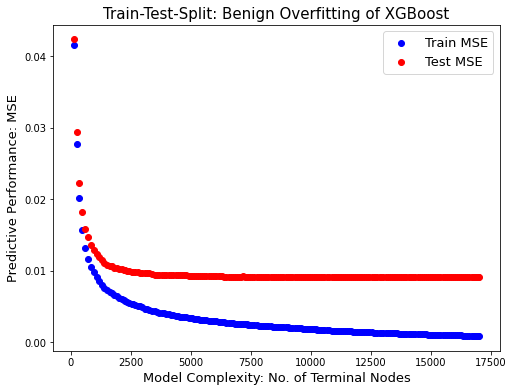

In [4]:
# Benign Overftting under train-test-split framework

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error

train_x, train_y = exp.get_model("XGBoost7").get_data(train=True)
test_x, test_y = exp.get_model("XGBoost7").get_data(test=True)

def score(clf, iteration_range):
    train_mse = mean_squared_error(train_y, clf.predict(train_x, iteration_range=iteration_range))
    test_mse = mean_squared_error(test_y, clf.predict(test_x, iteration_range=iteration_range))
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'train_mse': train_mse, 'test_mse': test_mse}

all_metrics = []
xgbinfo = clf.get_booster().trees_to_dataframe()
n_iter = 200
for i in range(n_iter):
    metrics = score(clf, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

plt.figure(figsize=(8,6))
plt.scatter(all_resluts["n_leaves"], all_resluts["train_mse"], color="blue", label="Train MSE")
plt.scatter(all_resluts["n_leaves"], all_resluts["test_mse"], color="red", label="Test MSE")
plt.legend(fontsize=13)
# plt.yscale("log")
plt.ylabel("Predictive Performance: MSE", fontsize=13)
plt.xlabel("Model Complexity: No. of Terminal Nodes", fontsize=13)
plt.title("Train-Test-Split: Benign Overfitting of XGBoost", fontsize=15)
plt.show()

In [6]:
# Choose XGBoost7, check Overfit
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Train Interpretable Models


In [7]:
# ----------------------------------
# Low-code Interface
# ----------------------------------

# Choose EBM, GAMI-Net, ReLU-DNN (default) and Sparse-ReLU-DNN (L1=0.0005)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [8]:
# ----------------------------------
# High-code Scripts (optional)
# ----------------------------------

# EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_result')

# GAMI-Net: GAMI Neural Networks by WF CMoR
from piml.models import GAMINetRegressor

clf = GAMINetRegressor(interact_num=10, 
                       subnet_size_main_effect=[20], 
                       subnet_size_interaction=[20, 20])
exp.model_train(model=clf, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_result')

# ReLU-DNN: ReLU Deep Neural Networks (default parameters)
from piml.models import ReluDNNRegressor

clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_result')

# Sparse-ReLU-DNN: set L1-Regularization to be 0.005
clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=0.0005,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='Sparse-ReLU-DNN')
exp.model_diagnose(model="Sparse-ReLU-DNN", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

,,MSE,MAE,R2
0,Train,0.010811,0.072170,0.809985
1,Test,0.011603,0.074227,0.790682
2,Gap,0.000792,0.002058,-0.019303


HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

,,MSE,MAE,R2
0,Train,0.011585,0.074184,0.796387
1,Test,0.012394,0.076799,0.776413
2,Gap,0.000809,0.002615,-0.019975


HTML(value="<p class='notification info'>Register ReLU-DNN Done</p>")

,,MSE,MAE,R2
0,Train,0.011659,0.073708,0.795091
1,Test,0.012315,0.076122,0.777847
2,Gap,0.000656,0.002414,-0.017244


HTML(value="<p class='notification info'>Register Sparse-ReLU-DNN Done</p>")

,,MSE,MAE,R2
0,Train,0.015536,0.088593,0.726948
1,Test,0.015671,0.089813,0.717296
2,Gap,0.000136,0.001220,-0.009652


# Interpret/Explain

In [9]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [10]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN, as well as arbitrary black-box models upon registration
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Diagnose/Compare

In [11]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [12]:
# Register Other Models, e.g. Shallow XGBoost

from xgboost import XGBRegressor

clf = XGBRegressor(max_depth=2, n_estimators=500)
pipeline = exp.make_pipeline(model=clf, name='XGBoost2')
pipeline.fit()
exp.register(pipeline=pipeline)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register XGBoost2 Done</p>")

In [13]:
# Compare EBM, GAMI-Net and XGBoost2 (Lower-order FANOVA models)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [14]:
# Compare ReLU-DNN, Sparse-ReLU-DNN, and XGBoost7 (Complex ML models)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>